In [19]:
import numpy as np
from scipy.integrate import solve_ivp
import cvxpy as cvx
import matplotlib.pyplot as plt

In [20]:
def quadrotor(t, state, control, M, J, g):
    x, y, theta, x_dot, y_dot, theta_dot = state
    u1, u2 = control
    
    dx = x_dot
    dy = y_dot
    dtheta = theta_dot
    dx_dot = u1*np.sin(theta) / M
    dy_dot = -g + (u1*np.cos(theta) / M)
    dtheta_dot = u2 / J
    
    return [dx, dy, dtheta, dx_dot, dy_dot, dtheta_dot]

In [21]:
def jacobian(state, control, M, J, g):
    x, y, theta, x_dot, y_dot, theta_dot = state
    u1, u2 = control
    
    J = [[ 0, 0, 0, 1, 0, 0],
         [ 0, 0, 0, 0, 1, 0],
         [ 0, 0, 0, 0, 0, 1],
         [ 0, 0, -u1*np.cos(theta)/M, 0, 0, 0],
         [ 0, 0, u2*np.sin(theta)/M, 0, 0, 0],
         [ 0, 0, 0, 0, 0, 0]]
    
    return J

In [22]:
# set constants

# Force Maximums
dim = 6
F_MAX = 40
M_MAX = 20
g = 9.81

# Virtual Position QP constants
M = 1
K1 = 0.2
E1 = np.sqrt(M)*np.sqrt(K1)
C1 = 0.001
eta1 = 10

# Orientation QP Constants
J = 0.25
K2 = 10
E2 = np.sqrt(J)*np.sqrt(K2)
lambda1 = 10
lambda2 = 10
eta2 = 20

In [23]:
# helper function - get desired angular speed
def get_dw(theta, d_theta):
    C2 = 0.01
    dw = 0
    
    diff = np.abs(theta - d_theta)
    d = np.min([diff, 2*np.pi - diff])
    i = np.argmin([diff, 2*np.pi - diff])
    
    if i == 0:
        if theta > d_theta:
            dw = -C2*d
        else:
            dw = C2*d
            
    if i == 1:
        if theta > d_theta:
            dw = C2*d
        else:
            dw = -C2*d    
        
    return dw

In [24]:
# set simulation constants

T = 100
dt = 0.01
n_iterations = int(T / dt)

x_0 = np.array([0, 0, 0, 0, 0, 0]) # initial position
x_end = np.array([50, 50, 0, 0, 0, 0]) # desired position

# Follow trajectory
r = 10
theta_traj = np.linspace(0, 2*np.pi, n_iterations)
x_traj = r * np.cos(theta_traj)
y_traj = r * np.sin(theta_traj)

In [25]:
# simulation initialization
x_hist = []
control_hist = []
x_hist.append(x_0)

#x_hist_2 = []
#control_hist_2 = []
#x_hist_2.append(x_0)

x = x_0
#d_pos = x_end

# jacobian estimation
jacobians = []
h = 1e-6
v = np.eye(dim)*h

print("Number of iterations: ", n_iterations)
for i in range(n_iterations):
    if (i % 100 == 0):
        print(i)
    
    d_pos = np.array([x_traj[i], y_traj[i]])
    
    ## POSITION QP
    pos = x[0:2]
    vel = x[3:5]
    d_vel = (-C1*(pos[0] - d_pos[0]), -C1*(pos[1] - d_pos[1]))
    
    # Set V_dot
    V1 = (M*(vel[0] - d_vel[0]) + E1*(pos[0] - d_pos[0]))
    V2 = (M*(vel[1] - d_vel[1]) + E1*(pos[1] - d_pos[1]))
    V3 = (K1*(pos[0] - d_pos[0]) + E1*(vel[0] - d_vel[0]))*vel[0]
    V4 = (K1*(pos[1] - d_pos[1]) + E1*(vel[1] - d_vel[1]))*vel[1]
    
    # Lyapunov Function - for exponential stabilization
    V = (M/2)*((vel[0] - d_vel[0])**2 + (vel[1] - d_vel[1])**2) + (K1/2)*((pos[0] - d_pos[0])**2 + (pos[1] - d_pos[1])**2) + E1*((pos[0] - d_pos[0])*(vel[0] - d_vel[0]) + (pos[1] - d_pos[1])*(vel[1] - d_vel[1]))
    
    # Define the matrix Q
    Q = np.array([[1, 0], [0, 1]])

    # virutal forces
    fv = cvx.Variable(2)  
    virtual_objective_function = cvx.Minimize(cvx.quad_form(fv, Q))  # Define the objective function
    constraints_virtual = [V1*fv[0] + V2*(fv[1] - g) + V3 + V4 + eta1*V <= 0]
    pos_QP = cvx.Problem(virtual_objective_function, constraints_virtual)
    pos_QP.solve(solver=cvx.CLARABEL)
    
    # calculate Fc and Theta_c
    theta = x[2]
    angle = np.array([np.sin(theta), np.cos(theta)]).T
    
    fv_ = np.array(fv.value)
    Fc = np.max((np.dot(fv_, angle), 0))
    Tc = np.arctan2(fv_[0], fv_[1])
    
    ## ORIENTATION LEVEL QP
    w = x[5]
    dw = get_dw(theta, Tc)
    
    # Set V_theta_dot
    V_theta1 = (K2*(theta - Tc) + E2*(w - dw))*w
    V_theta2 = (J*(w - dw) + E2*(theta - Tc))
    
    # Lyapunov Function - for exponential stabilization
    V_theta = (J/2)*(w - dw)**2 + (K2/2)*(theta - Tc)**2 + E2*(theta - Tc)*(w - dw)
    
    # QP
    u = cvx.Variable(2)
    slack = cvx.Variable(1)
    objective_function = cvx.Minimize(0.5*lambda1*(u[0] - Fc)**2 + 0.5*u[1]**2 + 0.5*lambda2*(slack**2))

    constraints = [V_theta1 + V_theta2*(u[1]/J) + eta2*V_theta <= slack, 
                u[0] >= 0, u[0] <= F_MAX,
                cvx.abs(u[1]) <= M_MAX]
    orientation_QP = cvx.Problem(objective_function, constraints)
    orientation_QP.solve(solver=cvx.CLARABEL)
    
    control = np.array(u.value)
    control_hist.append(control)
    
    # jacobian approximation
    jac = np.zeros(shape=(dim, dim))
    for j in range(dim):
        
        # Minus
        x_minus = x - v[:, j]
        pos_minus = x_minus[0:2]
        vel_minus = x_minus[3:5]
        d_vel_m = (-C1*(pos_minus[0] - d_pos[0]), -C1*(pos_minus[1] - d_pos[1]))
        
        # Set V_dot
        V1_m = (M*(vel_minus[0] - d_vel_m[0]) + E1*(pos_minus[0] - d_pos[0]))
        V2_m = (M*(vel_minus[1] - d_vel_m[1]) + E1*(pos_minus[1] - d_pos[1]))
        V3_m = (K1*(pos_minus[0] - d_pos[0]) + E1*(vel_minus[0] - d_vel_m[0]))*vel_minus[0]
        V4_m = (K1*(pos_minus[1] - d_pos[1]) + E1*(vel_minus[1] - d_vel_m[1]))*vel_minus[1]
        
        # Lyapunov Function - for exponential stabilization
        V_m = (M/2)*((vel_minus[0] - d_vel_m[0])**2 + (vel_minus[1] - d_vel_m[1])**2) + (K1/2)*((pos_minus[0] - d_pos[0])**2 + (pos_minus[1] - d_pos[1])**2) + E1*((pos_minus[0] - d_pos[0])*(vel_minus[0] - d_vel_m[0]) + (pos_minus[1] - d_pos[1])*(vel_minus[1] - d_vel_m[1]))
        
        # virutal forces
        fv_minus = cvx.Variable(2)  
        virtual_objective_function_m = cvx.Minimize(cvx.quad_form(fv_minus, Q))  # Define the objective function
        constraints_virtual_m = [V1_m*fv_minus[0] + V2_m*(fv_minus[1] - g) + V3_m + V4_m + eta1*V_m <= 0]
        pos_QP_m = cvx.Problem(virtual_objective_function_m, constraints_virtual_m)
        pos_QP_m.solve(solver=cvx.CLARABEL)
        
        # calculate Fc and Theta_c
        theta_minus = x_minus[2]
        angle_m = np.array([np.sin(theta_minus), np.cos(theta_minus)]).T
        
        fv_m = np.array(fv_minus.value)
        Fc_m = np.max((np.dot(fv_m, angle_m), 0))
        Tc_m = np.arctan2(fv_m[0], fv_m[1])
        
        ## ORIENTATION LEVEL QP
        w_minus = x_minus[5]
        dw_minus = get_dw(theta_minus, Tc_m)
        
        # Set V_theta_dot
        V_theta1_m = (K2*(theta_minus - Tc_m) + E2*(w_minus - dw_minus))*w_minus
        V_theta2_m = (J*(w_minus - dw_minus) + E2*(theta_minus - Tc_m))
        
        # Lyapunov Function - for exponential stabilization
        V_theta_m = (J/2)*(w_minus - dw_minus)**2 + (K2/2)*(theta_minus - Tc_m)**2 + E2*(theta_minus - Tc_m)*(w_minus - dw_minus)
        
        # QP
        u_minus = cvx.Variable(2)
        slack_m = cvx.Variable(1)
        objective_function_m = cvx.Minimize(0.5*lambda1*(u_minus[0] - Fc_m)**2 + 0.5*u_minus[1]**2 + 0.5*lambda2*(slack_m**2))

        constraints_m = [V_theta1_m + V_theta2_m*(u_minus[1]/J) + eta2*V_theta_m <= slack_m, 
                    u_minus[0] >= 0, u_minus[0] <= F_MAX,
                    cvx.abs(u_minus[1]) <= M_MAX]
        orientation_QP_m = cvx.Problem(objective_function_m, constraints_m)
        orientation_QP_m.solve(solver=cvx.CLARABEL)
        
        control_m = np.array(u_minus.value)
        
        # minus perturbation solution
        sol_minus = solve_ivp(quadrotor, [0, dt], x_minus, args=(control_m, M, J, g))
        x_sol_minus = sol_minus.y[:, -1]
        
        # PLUS
        x_plus = x + v[:, j]
        pos_plus = x_plus[0:2]
        vel_plus = x_plus[3:5]
        d_vel_p = (-C1*(pos_plus[0] - d_pos[0]), -C1*(pos_plus[1] - d_pos[1]))
        
        # Set V_dot
        V1_p = (M*(vel_plus[0] - d_vel_p[0]) + E1*(pos_plus[0] - d_pos[0]))
        V2_p = (M*(vel_plus[1] - d_vel_p[1]) + E1*(pos_plus[1] - d_pos[1]))
        V3_p = (K1*(pos_plus[0] - d_pos[0]) + E1*(vel_plus[0] - d_vel_p[0]))*vel_plus[0]
        V4_p = (K1*(pos_plus[1] - d_pos[1]) + E1*(vel_plus[1] - d_vel_p[1]))*vel_plus[1]
        
        # Lyapunov Function - for exponential stabilization
        V_p = (M/2)*((vel_plus[0] - d_vel_p[0])**2 + (vel_plus[1] - d_vel_p[1])**2) + (K1/2)*((pos_plus[0] - d_pos[0])**2 + (pos_plus[1] - d_pos[1])**2) + E1*((pos_plus[0] - d_pos[0])*(vel_plus[0] - d_vel_p[0]) + (pos_plus[1] - d_pos[1])*(vel_plus[1] - d_vel_p[1]))
        
        # virutal forces
        fv_plus = cvx.Variable(2)  
        virtual_objective_function_p = cvx.Minimize(cvx.quad_form(fv_plus, Q))  # Define the objective function
        constraints_virtual_p = [V1_p*fv_plus[0] + V2_p*(fv_plus[1] - g) + V3_p + V4_p + eta1*V_p <= 0]
        pos_QP_p = cvx.Problem(virtual_objective_function_p, constraints_virtual_p)
        pos_QP_p.solve(solver=cvx.CLARABEL)
        
        # calculate Fc and Theta_c
        theta_plus = x_plus[2]
        angle_p = np.array([np.sin(theta_plus), np.cos(theta_plus)]).T
        
        fv_p = np.array(fv_plus.value)
        Fc_p = np.max((np.dot(fv_p, angle_p), 0))
        Tc_p = np.arctan2(fv_p[0], fv_p[1])
        
        ## ORIENTATION LEVEL QP
        w_plus = x_plus[5]
        dw_plus = get_dw(theta_plus, Tc_p)
        
        # Set V_theta_dot
        V_theta1_p = (K2*(theta_plus - Tc_p) + E2*(w_plus - dw_plus))*w_plus
        V_theta2_p = (J*(w_plus - dw_plus) + E2*(theta_plus - Tc_p))
        
        # Lyapunov Function - for exponential stabilization
        V_theta_p = (J/2)*(w_plus - dw_plus)**2 + (K2/2)*(theta_plus - Tc_p)**2 + E2*(theta_plus - Tc_p)*(w_plus - dw_plus)
        
        # QP
        u_plus = cvx.Variable(2)
        slack_p = cvx.Variable(1)
        objective_function_p = cvx.Minimize(0.5*lambda1*(u_plus[0] - Fc_p)**2 + 0.5*u_plus[1]**2 + 0.5*lambda2*(slack_p**2))

        constraints_p = [V_theta1_p + V_theta2_p*(u_plus[1]/J) + eta2*V_theta_p <= slack_p, 
                    u_plus[0] >= 0, u_plus[0] <= F_MAX,
                    cvx.abs(u_plus[1]) <= M_MAX]
        orientation_QP_p = cvx.Problem(objective_function_p, constraints_p)
        orientation_QP_p.solve(solver=cvx.CLARABEL)
        
        control_p = np.array(u_plus.value)
        
        # minus perturbation solution
        sol_plus = solve_ivp(quadrotor, [0, dt], x_plus, args=(control_p, M, J, g))
        x_sol_plus = sol_plus.y[:, -1]
        
        # central difference quotient
        jac[:, j] = (x_sol_plus - x_sol_minus) / 2*h
        
    jacobians.append(jac)
    
    ## ODE INTEGRATOR
    sol = solve_ivp(quadrotor, [0, dt], x, args=(control, M, J, g))
    x = sol.y[:, -1]
    x_hist.append(x)
    
    

Number of iterations:  10000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [26]:
x_ = np.array(x_hist)
x_pos = x_[:, 0]
y_pos = x_[:, 1]
theta_pos = x_[:, 2]

control_hist = np.array(control_hist)
F_ = control_hist[:, 0]
M_ = control_hist[:, 1]

In [27]:
#x_2 = np.array(x_hist_2)
#x_pos_2 = x_2[:, 0]
#y_pos_2 = x_2[:, 1]

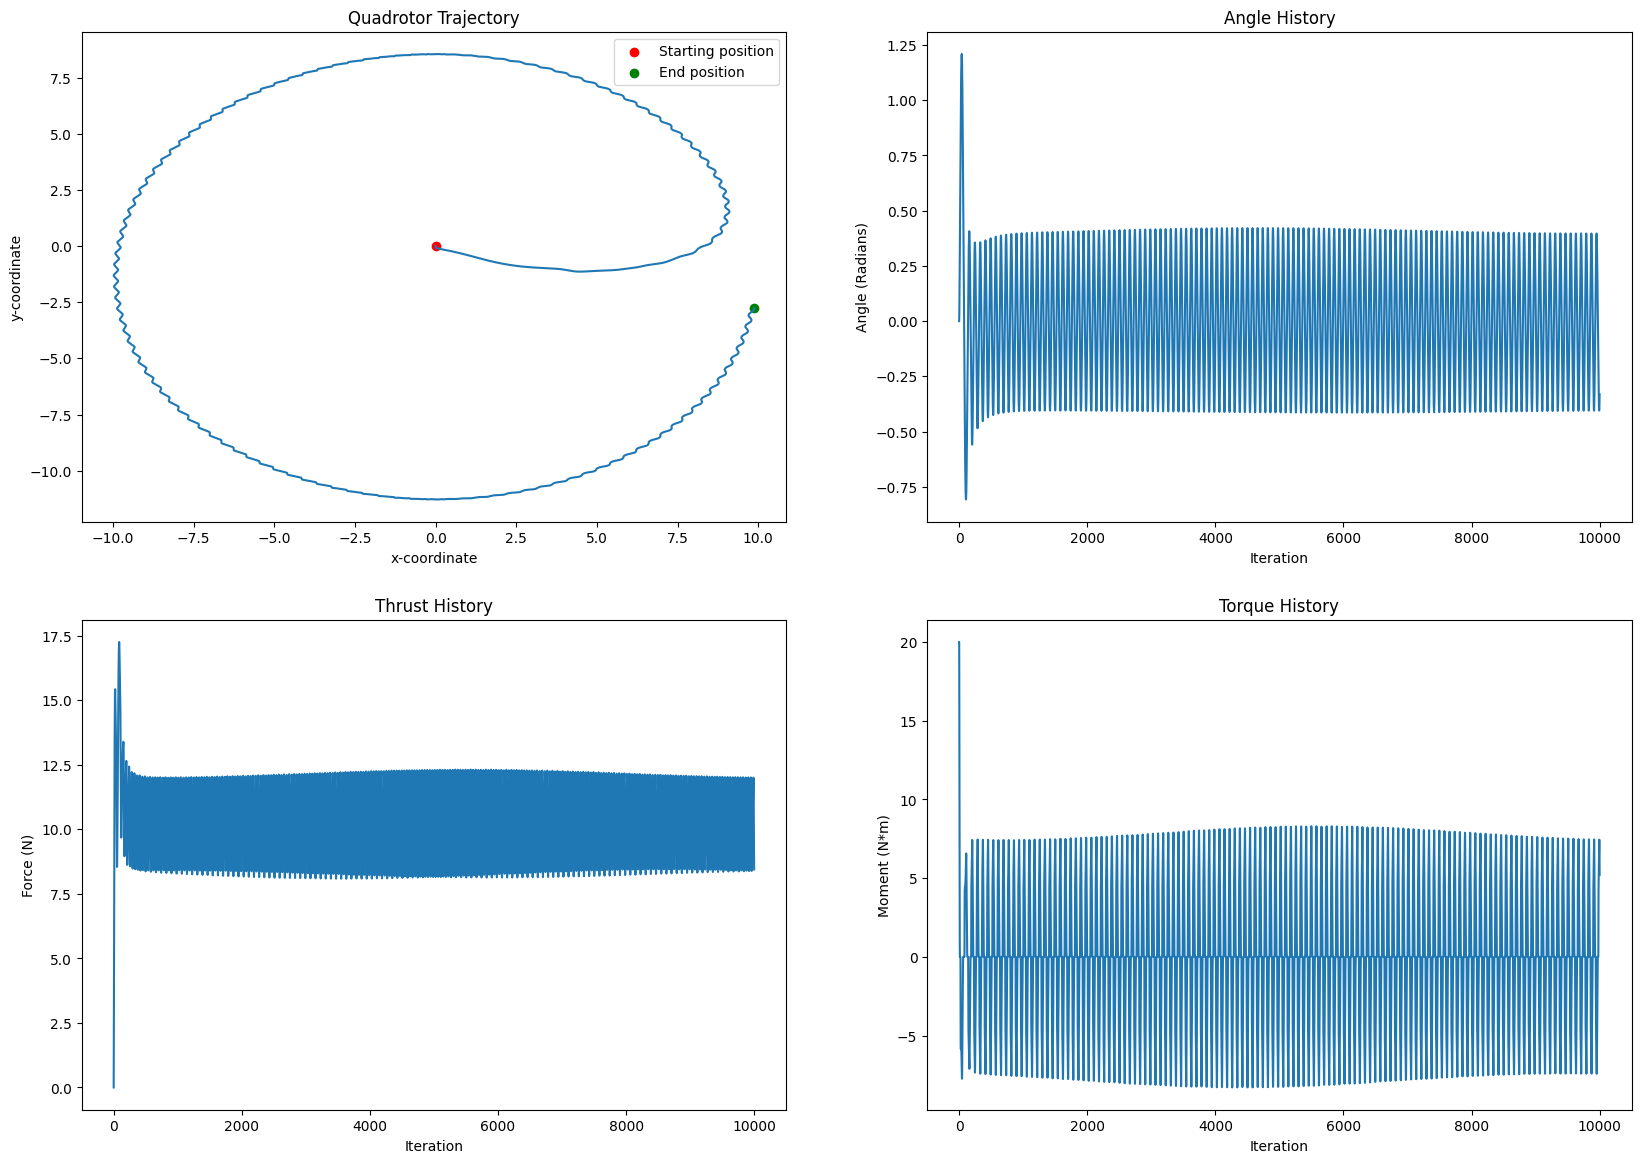

In [28]:
plt.figure(figsize=(20, 14))

plt.subplot(2, 2, 1)
plt.title('Quadrotor Trajectory')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.plot(x_pos, y_pos)
#plt.plot(x_pos_2, y_pos_2)
plt.scatter(x_pos[0], y_pos[0], color='red', label='Starting position')
plt.scatter(x_pos[-1], y_pos[-1], color='green', label='End position')
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Angle History')
plt.xlabel('Iteration')
plt.ylabel('Angle (Radians)')
plt.plot(theta_pos)

plt.subplot(2, 2, 3)
plt.title('Thrust History')
plt.xlabel('Iteration')
plt.ylabel('Force (N)')
plt.plot(F_)

plt.subplot(2, 2, 4)
plt.title('Torque History')
plt.xlabel('Iteration')
plt.ylabel('Moment (N*m)')
plt.plot(M_)


In [29]:
# Lyapunov exponent calculation
jacobians = np.array(jacobians)
Q = np.eye(dim)
lyap = []

for k in jacobians:
    Q_ = np.matmul(k, Q)
    Q, R = np.linalg.qr(Q_)
    
    lyap.append(np.log(abs(R.diagonal())))

lyap_exp = [sum([lyap[k][j] for k in range(n_iterations)]) / (n_iterations) for j in range(dim)]
print(lyap_exp)

[-27.63105211699004, -27.635639891449827, -27.635549480979808, -27.64586956799562, -27.72311661399906, -27.783211963070148]
